# CatGAN

## Install and Import Dependencies

In [22]:
download = False
if download:
    !git clone https://github.com/DennisRotondi/visiope_project
    !cd visiope_project
    !pip3 install -r requirements.txt

import os
import random
import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import PIL
from PIL import Image,ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import dataclasses
from dataclasses import dataclass
from dataclasses import asdict
from pprint import pprint
from typing import Sequence, List, Dict, Tuple, Optional, Any, Set, Union, Callable, Mapping

np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

Global seed set to 0


## Dataset Handling

In [35]:
class CatDataset(Dataset):
    
    def __init__(self, 
                 folder, 
                 transform = None
        ):
        
        super().__init__()
        self.folder = Path(folder)
        assert(self.folder.is_dir())
        self.files = list(sorted(self.folder.rglob('*.jpg')))
        assert(self.files)
        self.files_num = len(self.files)
        self.transform = transform

    def __len__(self):
        return self.files_num

    def pil_loader(self,file):
        with file.open('rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
        file = self.files[index % self.files_num]
        image = self.pil_loader(file)

        if self.transform is not None:
            image = self.transform(image)
        
        return {
            'file': image,
            'path': str(file)
        }
        
def plot_cats(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Cats images'):
    plt.figure(figsize = (16, 16))
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

visualize some cats from the dataset

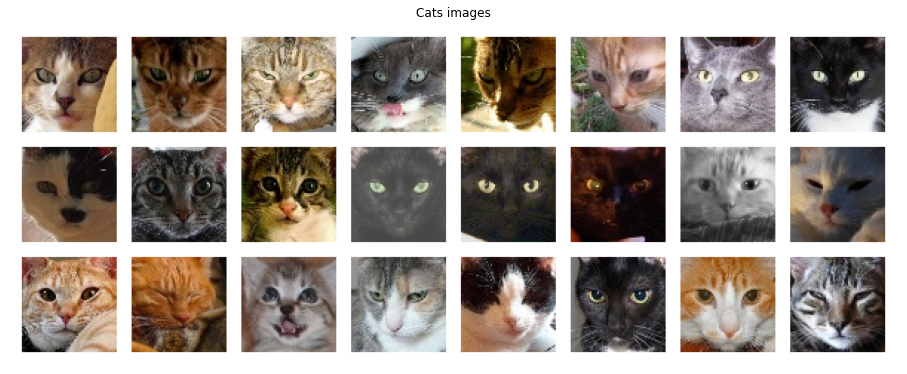

In [43]:
path = "./cats"

catsData = DataLoader(
    CatDataset(
        path,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=24,
    shuffle=True,
)
batch = iter(catsData).next()
plot_cats(batch["file"], images_per_row=8, title="Cats images")

## GAN Model

### Hyperparameters

In [46]:
@dataclass
class Hparams:
    n_epochs: int = 200  # number of epochs of training
    img_height: int = 64  # size of image height # default 256x256
    img_width: int = 64  # size of image width
    batch_size: int = 128  # size of the batches
    lrg: float = 3e-4  # optimizer: learning rate for generator
    lrd: float = 3e-4  # optimizer: learning rate for discriminator
    wdg: float = 1e-4  # weight_decay for generator
    wdd: float = 1e-4  # wd for discriminator
    channels: int = 3  # number of image channels
    n_cpu: int = 8  # number of cpu threads to use for the dataloaders
    latent_dim: int = 128
hparams = asdict(Hparams())
pprint(hparams)

{'batch_size': 128,
 'channels': 3,
 'img_height': 64,
 'img_width': 64,
 'latent_dim': 128,
 'lrd': 0.0003,
 'lrg': 0.0003,
 'n_cpu': 8,
 'n_epochs': 200,
 'wdd': 0.0001,
 'wdg': 0.0001}


In [73]:
class Generator(nn.Module):
    def __init__(self,hparams):
        super(Generator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams['channels'], hparams['img_height'], hparams['img_width'])
        
        #built according to this benchmark: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
        def gan_block(in_features, out_features, normalize=True):
            layer = [nn.Linear(in_features, out_features)]
            layer.append(nn.PReLU())
            if normalize:
                layer.append(nn.BatchNorm1d(out_features))
            layer.append(nn.Dropout(0.2))
            return layer

        self.model = nn.Sequential(
            *gan_block(self.hparams['latent_dim'], 128, normalize=False),
            *gan_block(128, 256),
            *gan_block(256, 512),
            *gan_block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self,hparams):
        super(Discriminator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams['channels'], hparams['img_height'], hparams['img_width'])
        
        #linear layers to not make discriminator much better than generator (using convolutions it would be really easy to classify bad examples)
        self.layers = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 2048),
            nn.PReLU(),
            nn.Linear(2048, 1024),
            nn.PReLU(),
            nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_linear = img.view(img.size(0), -1)
        img_class = self.layers(img_linear)
        return img_class

In [81]:
class CatGAN_Trainer():
    def __init__(
        self,
        generator,
        discriminator,
        loss_function,
        optimizer_g,
        optimizer_d,
        device,
        hparams,
        log_steps:int=10, #how many epochs save images to plot (using valid_samples)
        log_level:int=2):

        self.device = device
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        self.loss_function = loss_function
        self.optimizer_g = optimizer_g
        self.optimizer_d = optimizer_d
        
        self.hparams = hparams
        self.log_steps = log_steps
        self.log_level = log_level
        
        self.valid_samples = torch.randn(8, self.hparams['latent_dim']).to(self.device)
        self.gen_train_loss = list()
        self.dis_fake_loss = list()
        self.dis_real_loss = list()
        self.training_imgs = list()
        
    def train(self, train_dataset:Dataset, epochs:int=1):
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')    
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch + 1))

            epoch_gen_loss = 0.0
            epoch_dis_fake_loss = 0.0
            epoch_dis_real_loss = 0.0
            self.generator.train()
            self.discriminator.train()
            # for each batch 
            for step, sample in enumerate(train_dataset):
                imgs = sample['file'].to(self.device)
                # sample noise
                z = torch.randn(imgs.shape[0], self.hparams['latent_dim']).type_as(imgs).to(self.device)
                self.optimizer_g.zero_grad()
                # train generator
                # generate images
                generated_imgs = self.generator(z) #! log sampled images if you want
                # to train the generator we have to follow the direction in which the
                # discriminator classifies fake images as real
                valid = torch.ones(imgs.size(0), 1).type_as(imgs)
                g_loss = self.loss_function(self.discriminator(generated_imgs), valid)
                epoch_gen_loss += g_loss
                g_loss.backward()
                self.optimizer_g.step()
                self.optimizer_d.zero_grad()
                #we train on real images to be discriminated as real
                real_loss = self.loss_function(self.discriminator(imgs), valid)
                epoch_dis_real_loss += real_loss
                #we train of fake images to be discriminated as fake
                fake = torch.zeros(imgs.size(0), 1).type_as(imgs)
                #! here I could implement buffer technique 
                fake_loss = self.loss_function(self.discriminator(generated_imgs.detach()), fake)
                epoch_dis_fake_loss += fake_loss
                # discriminator loss is half the sum of these
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                self.optimizer_d.step()
            self.gen_train_loss.append(epoch_gen_loss.tolist())
            self.dis_fake_loss.append(epoch_dis_fake_loss.tolist())
            self.dis_real_loss.append(epoch_dis_real_loss.tolist())
            if epoch % self.log_steps == 0:
                sample_imgs = self.generator(self.valid_samples)
                grid = torchvision.utils.make_grid(sample_imgs.cpu(),4,10,1).permute(1, 2, 0)
                self.training_imgs.append(grid)
            if self.log_level > 0:
                print('\t[E: {:2d}] gen train loss = {:0.4f}'.format(epoch, epoch_gen_loss))
                print('\t[E: {:2d}] dis fake loss = {:0.4f}'.format(epoch, epoch_dis_fake_loss))
                print('\t[E: {:2d}] gen real loss = {:0.4f}'.format(epoch, epoch_dis_real_loss))
        if self.log_level > 0:
            print('... Done!')

In [75]:
generator = Generator(hparams)
discriminator = Discriminator(hparams)
optimizer_g = optim.Adam(generator.parameters(), lr=hparams['lrg'], weight_decay=hparams['wdg'])
optimizer_d = optim.Adam(discriminator.parameters(), lr=hparams['lrd'], weight_decay=hparams['wdd'])
loss = F.binary_cross_entropy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_folder = "./cats"
image_transforms = transforms.Compose(
            [
                transforms.ToTensor()
            ]
        )
train_loader = DataLoader(
            CatDataset(
                train_folder, transform=image_transforms
            ),
            batch_size = hparams['batch_size'],
            shuffle=True,
            num_workers = hparams['n_cpu']
        )

catGAN_T = CatGAN_Trainer(generator,discriminator,loss,optimizer_g,optimizer_d,device,hparams)


Training ...
 Epoch 001
	[E:  0] gen train loss = 3988.2957
	[E:  0] dis fake loss = 211.7233
	[E:  0] gen real loss = 14.1176
 Epoch 002
	[E:  1] gen train loss = 4400.1465
	[E:  1] dis fake loss = 51.8607
	[E:  1] gen real loss = 65.2446
 Epoch 003
	[E:  2] gen train loss = 3947.4163
	[E:  2] dis fake loss = 27.1626
	[E:  2] gen real loss = 35.9189
 Epoch 004
	[E:  3] gen train loss = 3702.6550
	[E:  3] dis fake loss = 5.3479
	[E:  3] gen real loss = 5.4155
 Epoch 005
	[E:  4] gen train loss = 4015.9382
	[E:  4] dis fake loss = 56.9628
	[E:  4] gen real loss = 21.2815
 Epoch 006
	[E:  5] gen train loss = 4431.1973
	[E:  5] dis fake loss = 43.1463
	[E:  5] gen real loss = 45.9607
 Epoch 007
	[E:  6] gen train loss = 3145.0974
	[E:  6] dis fake loss = 28.7303
	[E:  6] gen real loss = 42.9504
 Epoch 008
	[E:  7] gen train loss = 4897.8828
	[E:  7] dis fake loss = 26.0485
	[E:  7] gen real loss = 33.3536
 Epoch 009
	[E:  8] gen train loss = 3363.6050
	[E:  8] dis fake loss = 30.3395
	[E:

In [82]:
catGAN_T.train(train_loader,20)

Training ...
 Epoch 001
	[E:  0] gen train loss = 769.9517
	[E:  0] dis fake loss = 8.8056
	[E:  0] gen real loss = 19.4751
 Epoch 002
	[E:  1] gen train loss = 738.7032
	[E:  1] dis fake loss = 20.8217
	[E:  1] gen real loss = 55.8622
 Epoch 003
	[E:  2] gen train loss = 794.1453
	[E:  2] dis fake loss = 12.9628
	[E:  2] gen real loss = 23.5157
 Epoch 004
	[E:  3] gen train loss = 743.5219
	[E:  3] dis fake loss = 10.7056
	[E:  3] gen real loss = 21.5697
 Epoch 005
	[E:  4] gen train loss = 750.6331
	[E:  4] dis fake loss = 21.4389
	[E:  4] gen real loss = 71.6961
 Epoch 006
	[E:  5] gen train loss = 729.5797
	[E:  5] dis fake loss = 32.1138
	[E:  5] gen real loss = 31.6381
 Epoch 007
	[E:  6] gen train loss = 908.0765
	[E:  6] dis fake loss = 10.7333
	[E:  6] gen real loss = 20.4678
 Epoch 008
	[E:  7] gen train loss = 801.8907
	[E:  7] dis fake loss = 15.9576
	[E:  7] gen real loss = 38.8186
 Epoch 009
	[E:  8] gen train loss = 838.6295
	[E:  8] dis fake loss = 16.7156
	[E:  8] gen 

### Plot results of traning

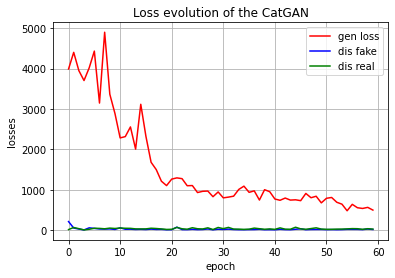

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


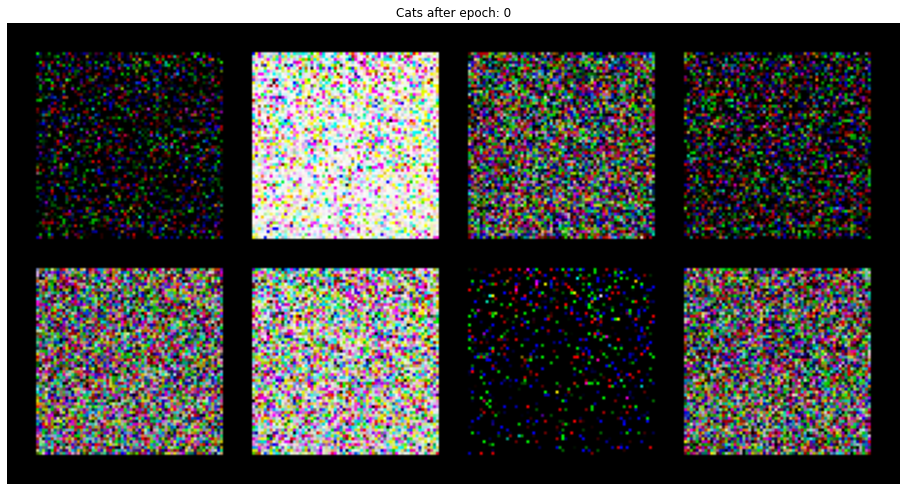

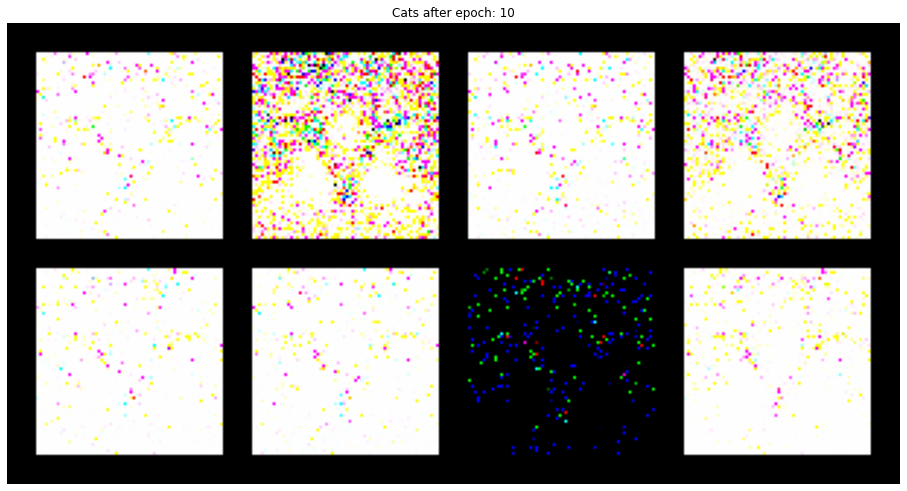

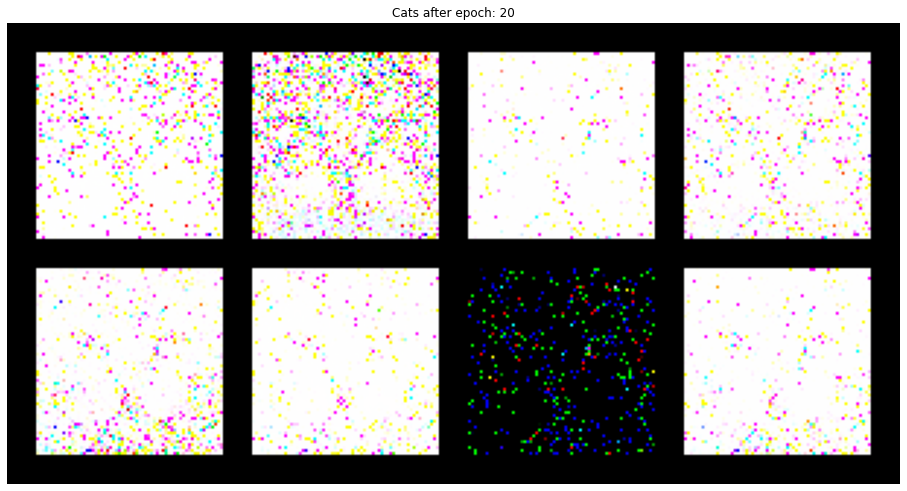

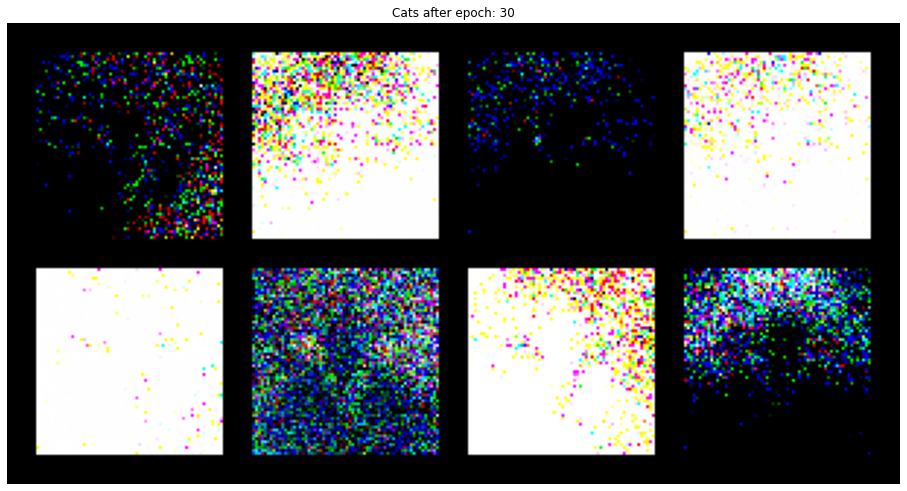

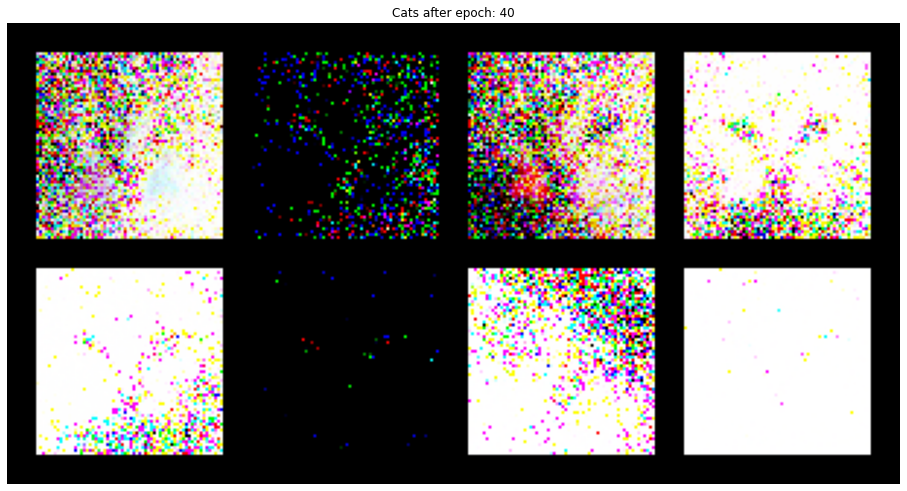

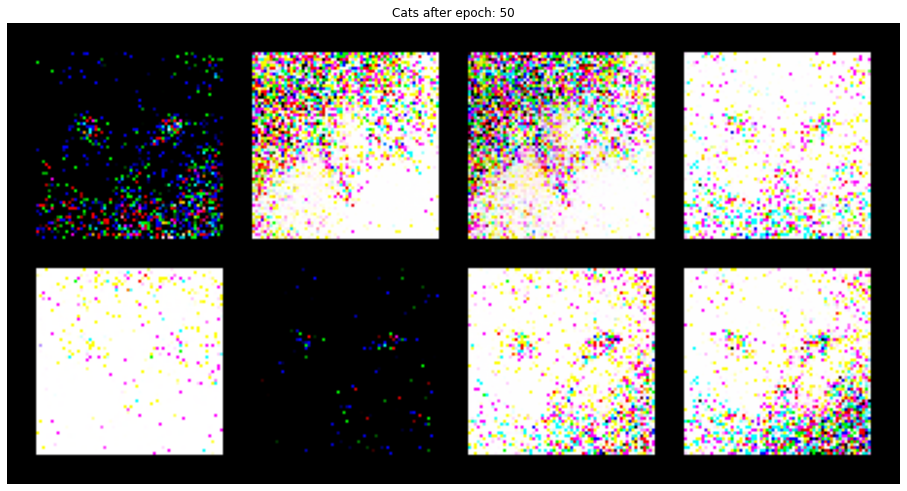

In [83]:
X=np.arange(len(catGAN_T.gen_train_loss))

plt.plot(X, catGAN_T.gen_train_loss, color='r', label='gen loss')
plt.plot(X, catGAN_T.dis_fake_loss, color='b', label='dis fake')
plt.plot(X, catGAN_T.dis_real_loss, color='g', label='dis real')

plt.xlabel("epoch")
plt.ylabel("losses")
plt.title("Loss evolution of the CatGAN")
plt.legend()
plt.grid()
plt.show()

for idx,grid in enumerate(catGAN_T.training_imgs):
    plt.figure(figsize = (16, 16))
    plt.imshow(grid)
    plt.title("Cats after epoch: {}".format(idx*catGAN_T.log_steps))
    plt.axis('off') 